In [11]:
# import packages

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


import re

# data visualization
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from plotly import offline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

# change text color
import colorama
from colorama import Fore, Style

# IPython
from IPython.display import IFrame

from sklearn.feature_selection import mutual_info_classif

%matplotlib inline

In [12]:

train = pd.read_csv("../data/train_clean.gz",index_col=0)
test = pd.read_csv("../data/test_clean.gz",index_col=0)

In [13]:
fullset = pd.concat([train, test])

In [14]:
from data_management import meta

In [15]:
metadata = meta(train,test)

## Encoding


### LabelEncoder

> Encode target labels with value between 0 and n_classes-1.

```




### OrdinalEncoder


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

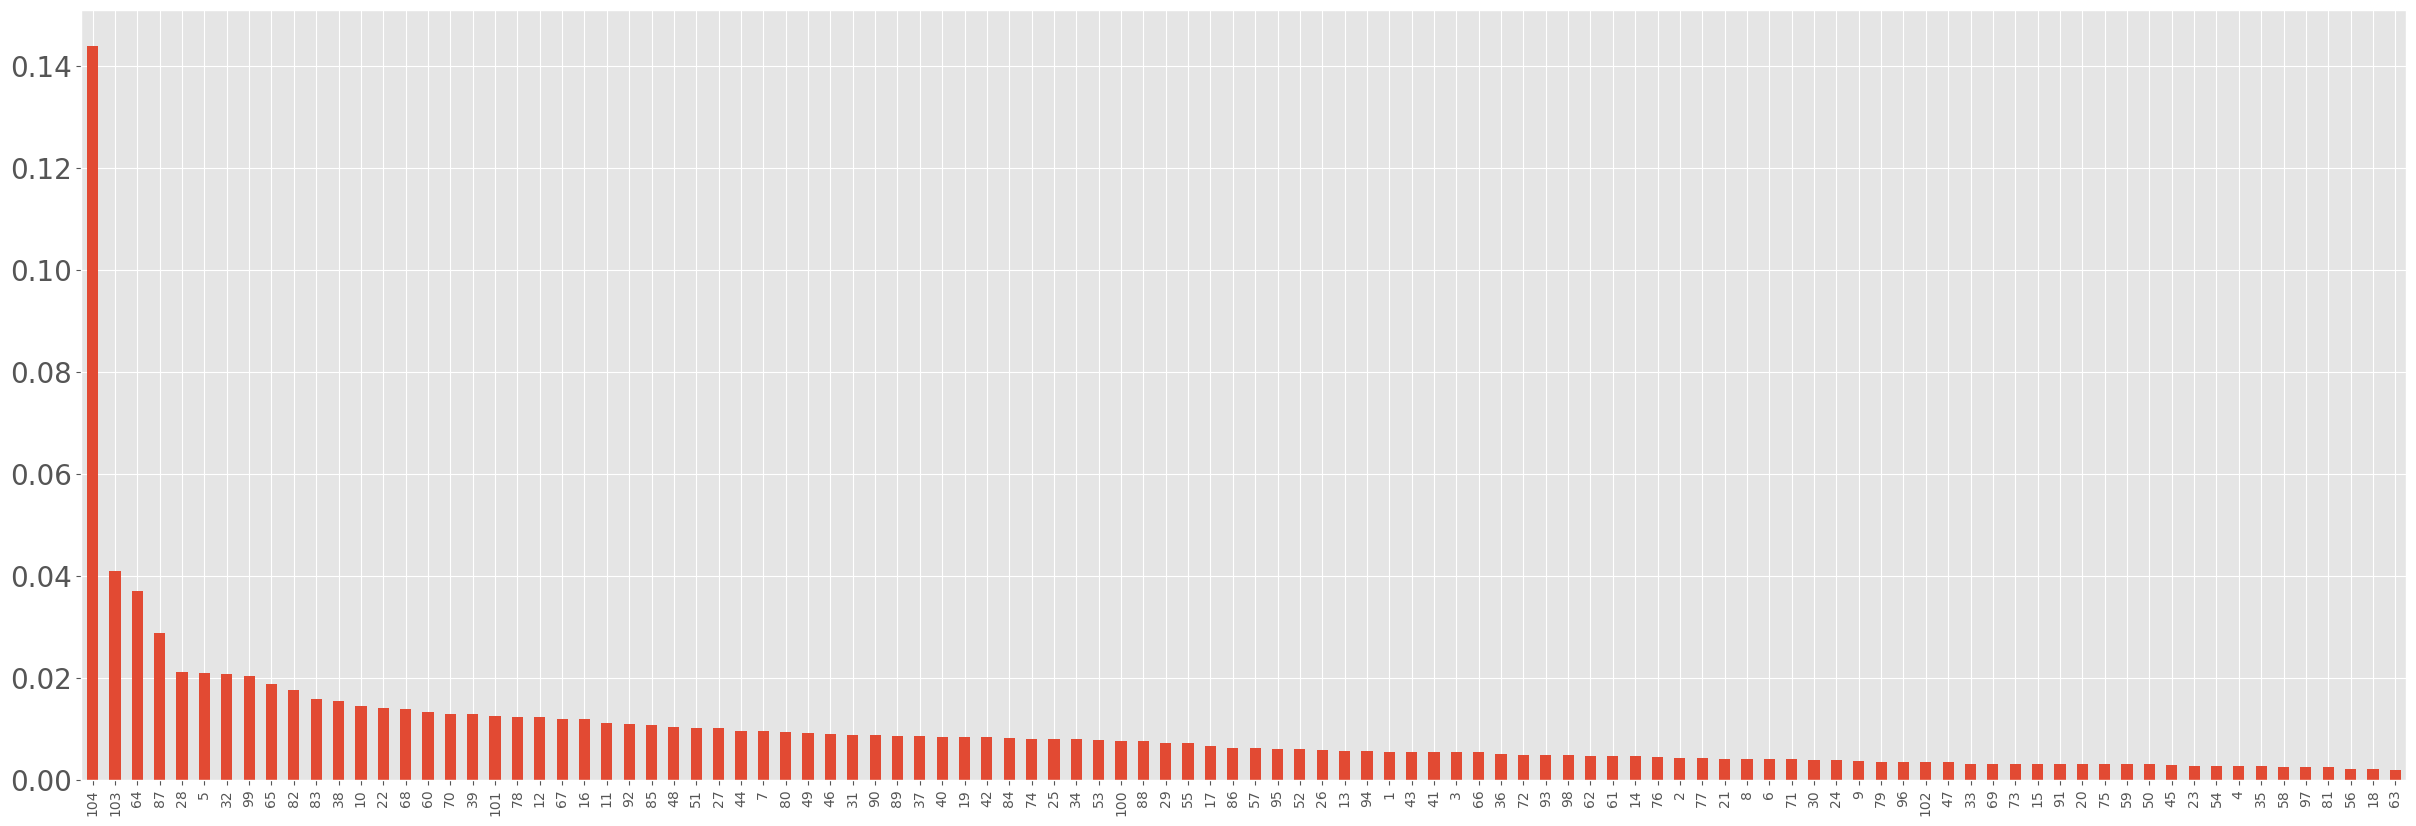

In [16]:
(fullset.ps_car_11_cat.value_counts()/fullset.shape[0]).plot(kind='bar',figsize = [30,10])
plt.tick_params(axis='y', which='major', labelsize=20)



### OneHotEncoder


In [17]:
nominal_cols = metadata[(metadata.level == 'nominal') & (metadata.keep == True)].index.tolist()
nominal_cols

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [18]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore",sparse=False)
trn_nominal_cols_enc = enc.fit_transform(train[nominal_cols])
tst_nominal_cols_enc = enc.transform(test[nominal_cols])

In [19]:
trn_nominal_cols_enc.shape

(144626, 177)

In [20]:
tst_nominal_cols_enc.shape

(892816, 177)

In [21]:
enc = OneHotEncoder(handle_unknown='ignore')
X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(X)

OneHotEncoder(handle_unknown='ignore')

In [22]:

enc.categories_

[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]

In [23]:
enc.transform([['Female', 1], ['Male', 4]]).toarray()

array([[1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [24]:
enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])

array([['Male', 1],
       [None, 2]], dtype=object)

In [25]:
enc.get_feature_names_out(['gender', 'group'])

array(['gender_Female', 'gender_Male', 'group_1', 'group_2', 'group_3'],
      dtype=object)

### TargetEncoder



In [26]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)

    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])

    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))

    prior = target.mean()

    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)

    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [27]:
from sklearn.model_selection import train_test_split

X_trn, X_val, y_trn, y_val = train_test_split(
    train.drop('target',axis=1), train.target, test_size=0.2, random_state=1996)

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
f_cats = [f for f in X_trn.columns if "_cat" in f]

min_samples_leaf = 100
smoothing = 10
noise_level=0.01

print(f"min_samples_leaf:{Fore.BLUE}{min_samples_leaf}{Style.RESET_ALL}\n"
      f"smoothing:{Fore.BLUE}{smoothing}{Style.RESET_ALL}\n"
      f"noise_level:{Fore.BLUE}{noise_level}{Style.RESET_ALL}")

print("-"*100)
print("%20s   %20s  %25s  %22s" % ("", f"{Fore.BLUE}before{Style.RESET_ALL}", 
                                   f"{Fore.RED}after{Style.RESET_ALL}", 
                                   f"{Fore.GREEN}changes{Style.RESET_ALL}"))
for f in f_cats:
    print("%-20s: " % f, end="")
    tf_scores = []
    f_scores = []
    for trn_idx, val_idx in folds.split(X_trn.values, y_trn.values):
        trn_f, trn_tgt = X_trn[f].iloc[trn_idx], y_trn.iloc[trn_idx]
        val_f, val_tgt = X_trn[f].iloc[trn_idx], y_trn.iloc[trn_idx]
        trn_tf, val_tf = target_encode(trn_series=trn_f, 
                                       tst_series=val_f, 
                                       target=trn_tgt, 
                                       min_samples_leaf=min_samples_leaf, 
                                       smoothing=smoothing,
                                       noise_level=noise_level)
        f_scores.append(max(roc_auc_score(val_tgt, val_f), 1 - roc_auc_score(val_tgt, val_f)))
        tf_scores.append(roc_auc_score(val_tgt, val_tf))
    print(" %.6f ± %.6f | %6f ± %.6f | %6f" 
          % (np.mean(f_scores), np.std(f_scores), np.mean(tf_scores), np.std(tf_scores), np.mean(tf_scores)-np.mean(f_scores)))

min_samples_leaf:100
smoothing:10
noise_level:0.01
----------------------------------------------------------------------------------------------------
                            before             after        changes
ps_ind_02_cat       :  0.508104 ± 0.000422 | 0.509645 ± 0.000867 | 0.001541
ps_ind_04_cat       :  0.512504 ± 0.000825 | 0.513281 ± 0.000657 | 0.000777
ps_ind_05_cat       :  0.519149 ± 0.000840 | 0.533329 ± 0.003314 | 0.014180
ps_car_01_cat       :  0.527362 ± 0.000694 | 0.552239 ± 0.001356 | 0.024877
ps_car_02_cat       :  0.532023 ± 0.000185 | 0.531681 ± 0.001505 | -0.000341
ps_car_03_cat       :  0.539585 ± 0.001345 | 0.540544 ± 0.001791 | 0.000958
ps_car_04_cat       :  0.537897 ± 0.000764 | 0.534984 ± 0.001891 | -0.002913
ps_car_05_cat       :  0.531300 ± 0.001056 | 0.532119 ± 0.000979 | 0.000819
ps_car_06_cat       :  0.517316 ± 0.000678 | 0.541762 ± 0.000785 | 0.024446
ps_car_07_cat       :  0.523654 ± 0.000581 | 0.523492 ± 0.001293 | -0.000162
ps_car_08_cat    

In [29]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)

In [30]:
train["ps_car_11_cat_tar_enc"] = train_encoded.astype('float64')
test['ps_car_11_cat_tar_enc'] = test_encoded.astype('float64')

In [31]:
cols_to_drop = metadata[metadata['imputation'] == 'remove'].index.tolist()

In [32]:
cols_to_drop.append('ps_car_11_cat')

In [33]:
train_clean = train.drop(cols_to_drop,axis=1)

In [34]:
test_clean = test.drop(cols_to_drop,axis=1)

In [35]:
train_clean.to_csv('train_clean.csv')
test_clean.to_csv('test_clean.csv')

In [36]:
fullset = pd.concat([train_clean,test_clean],ignore_index=True)

In [37]:
continuous_cols = metadata[(metadata.level == 'interval')|(metadata.level == 'ratio') & (metadata.keep == True)].index.tolist()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

<AxesSubplot: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

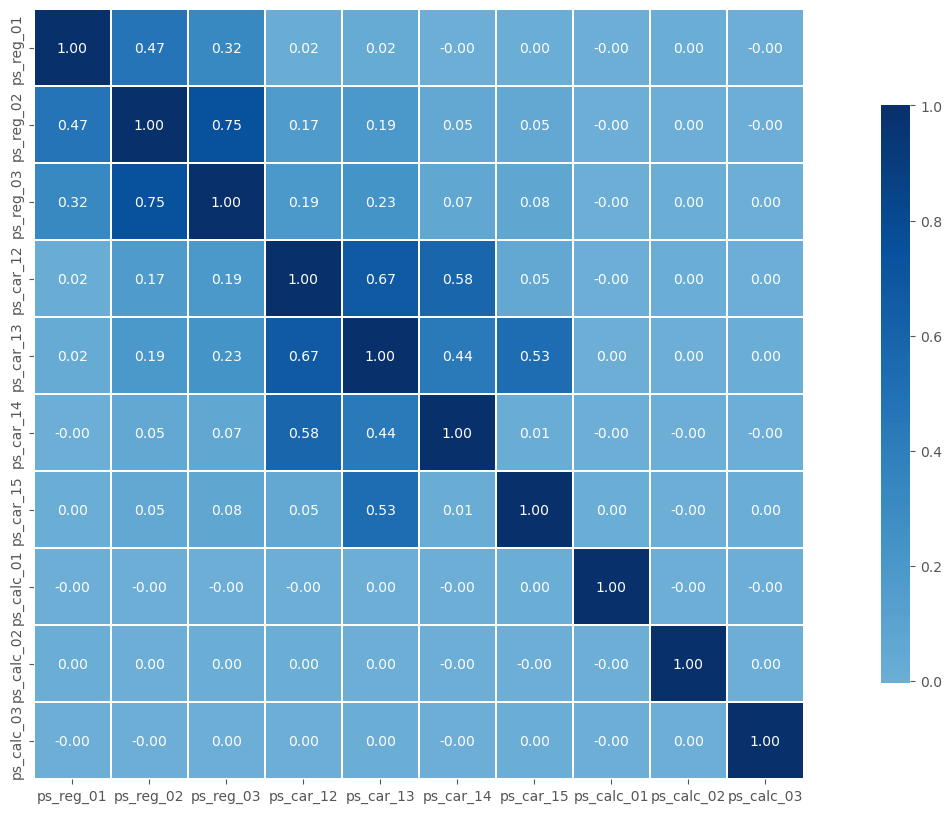

In [38]:
plt.figure(figsize = [20,10])  
sns.heatmap(data = fullset[continuous_cols].corr(), 
            vmax=1,
            center=0,
            square=True,
           annot = True,  
          fmt='.2f',      
           cmap = 'Blues',   
           linewidths = .3, 
           cbar_kws={"shrink": .75})




### Standardization




### Normalization


### PCA



Total Explained variance: 0.9948


Text(0, 0.5, 'second principle 2.5 % Variance')

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

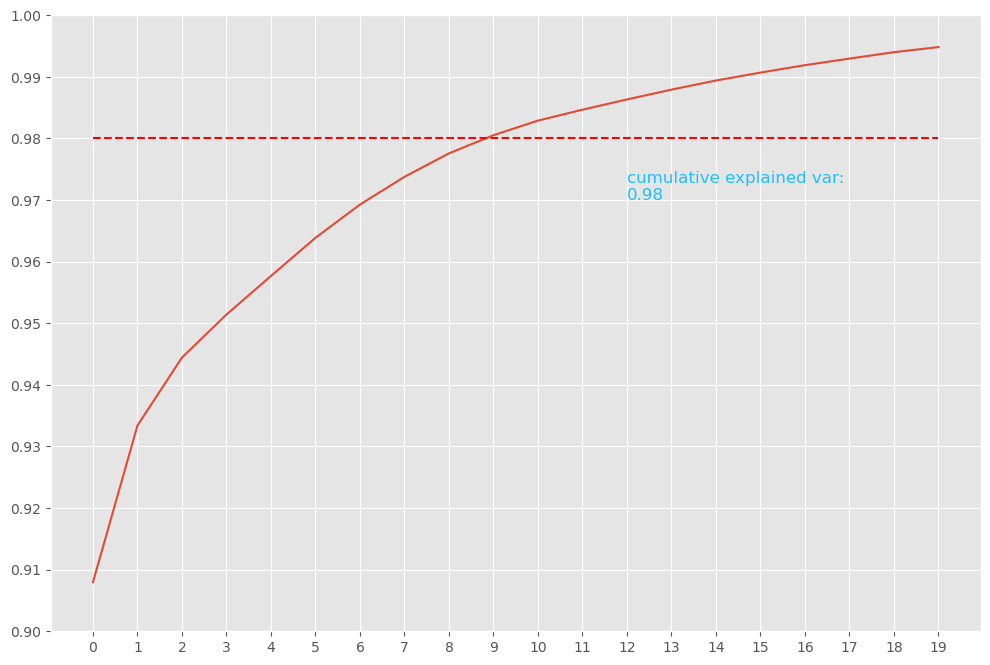

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

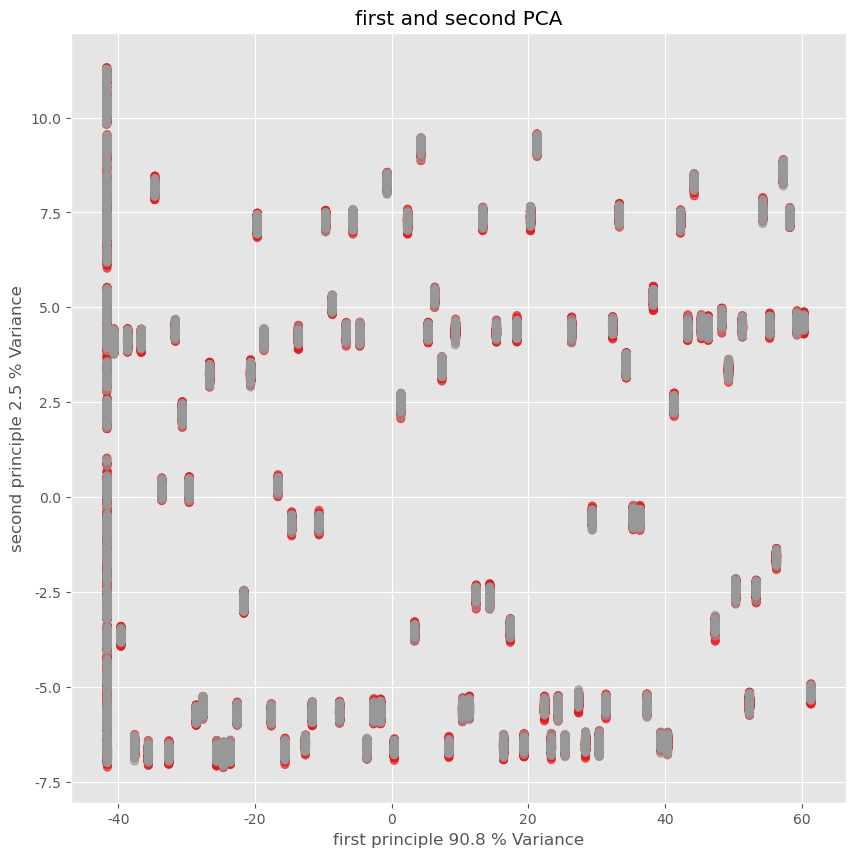

In [39]:
from sklearn.decomposition import PCA

X = train.drop(['id', 'target'], axis=1)
y = train.target

n_comp = 20

pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(X)
print('Total Explained variance: %.4f' % pca.explained_variance_ratio_.sum())


plt.figure(figsize = [12,8])

pd.Series(pca.explained_variance_ratio_).cumsum().plot()

plt.plot(range(n_comp),[0.98]*20, 'r--')
plt.xticks(ticks = range(n_comp))
plt.yticks(ticks = np.linspace(0.9,1,11))
plt.text(12,0.97,'cumulative explained var: \n0.98',fontsize = 12, color = '#20beff')

plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0],X_pca[:,1],c=y,cmap='Set1',alpha = .7)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title(
        "first and second PCA")
plt.xlabel("first principle %.1f %% Variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("second principle %.1f %% Variance" % (
        pca.explained_variance_ratio_[1] * 100.0))

In [40]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=.01)
selector.fit(fullset.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = fullset.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))

8 variables have too low variance.


In [43]:
! pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 899.2 kB/s eta 0:00:0000:0100:01


In [44]:
from xgboost import XGBClassifier
from xgboost import plot_importance

plt.figure(figsize = [100,20])

X = train.drop(['id', 'target'], axis=1)
y = train.target

model = XGBClassifier()

model.fit(X, y)
# plot feature importance

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Figure size 10000x2000 with 0 Axes>

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

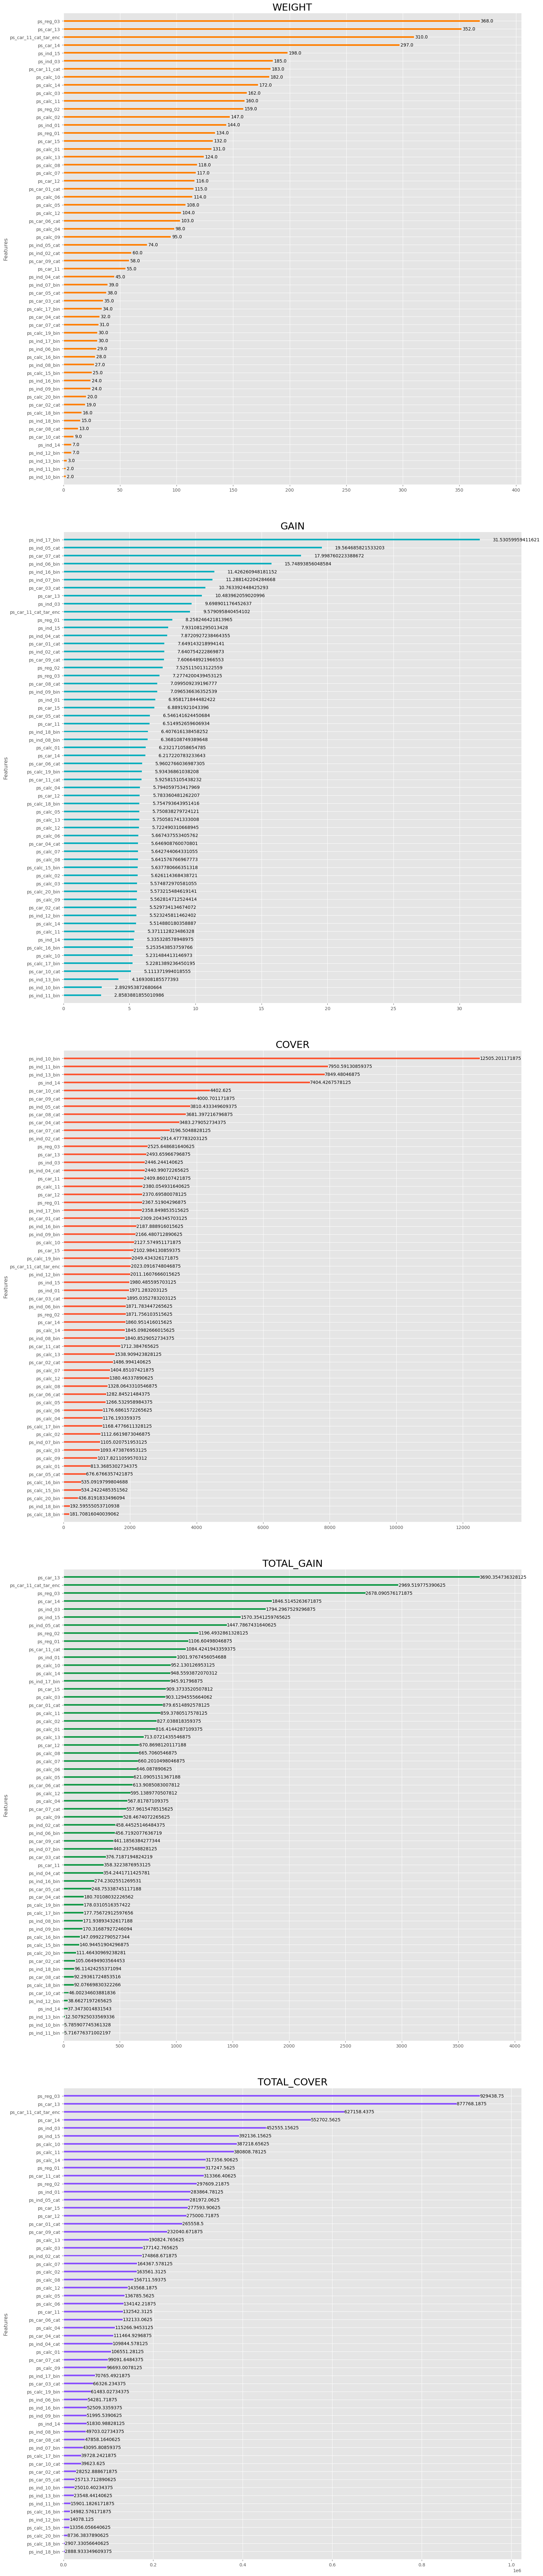

In [45]:
# define subplot grid
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15, 80))
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
# loop through tickers and axes
colors = ['#ff7f01','#08aebd','#fc5531','#139948','#8950fe']
for ty, ax, color in zip(types, axs.ravel(), colors):
    # filter df for ticker and plot on specified axes
    plot_importance(ax = ax, booster = model,importance_type=ty, color = color)

    # chart formatting
    ax.set_title(ty.upper(),fontsize = 22)
    ax.set_xlabel("")

plt.show()

In [46]:
from sklearn.feature_selection import SelectFromModel
feat_dict = {}
for thres in ['median','mean','1.25*mean']:
    model_select = SelectFromModel(model, threshold=thres, prefit=True)
    print(f'before: {X.shape[1]}features')
    n_features = model_select.transform(X.values).shape[1]
    print(f'after: {n_features}features【{thres}】')
    print('#'*60)
    selected_vars = list(X.columns[model_select.get_support()])
    feat_dict[thres] = selected_vars

before: 58features
after: 29features【median】
############################################################
before: 58features
after: 16features【mean】
############################################################
before: 58features
after: 10features【1.25*mean】
############################################################


In [48]:
for ty in types:
    feat_dict[ty] = list(model.get_booster().get_score(importance_type=ty).keys())

In [50]:
final_train = train[feat_dict['mean']+['target']]
final_test = test.loc[test.index][feat_dict['mean']]

In [51]:
final_train.to_csv("../data/final_train.csv")
final_test.to_csv("../data/final_test.csv")